# AutoML

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/automl.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebooks covers AutoML utilities of ETNA library.

- [Hyperparameters tuning](#chapter_1)
    - [How `Tune` works](#section_1_1)
    - [Example](#section_1_2)
- [General AutoML](#chapter_2)
    - [How `Auto` works](#section_2_1)
    - [Example](#section_2_2)

In [1]:
import warnings


warnings.filterwarnings("ignore")

In [2]:
HORIZON = 14

Many features from this notebook require `auto` extension. You can install it by the command:
```bash
pip install etna[auto]
```

## 1. Hyperparameters tuning <a class="anchor" id="chapter_1"></a>

It is a common task to tune hyperparameters of existing pipeline to improve its quality. For this purpose there is an `etna.auto.Tune` class, which is responsible for creating [optuna](https://github.com/optuna/optuna) study to solve this problem.

In the next sections we will see how it works and how to use it for your particular problems.

### 1.1 How `Tune` works <a class="anchor" id="section_1_1"></a>

During init `Tune` accepts `pipeline`, its tuning parameters (`params_to_tune`), optimization metric (`target_metric`), parameters of backtest and parameters of optuna study.

In `fit` the optuna study is created. During each trial the sample of parameters is generated from `params_to_tune` and applied to `pipeline`. After that, the new pipeline is checked in backtest and target metric is returned to optuna framework.

Let's look closer at `params_to_tune` parameter. It expects dictionary with parameter names and its distributions. But how this parameter names should be chosen?

#### 1.1.1 `set_params`

We are going to make a little detour to explain the `set_params` method, which is supported by ETNA pipelines, models and transforms. Given a dictionary with parameters it allows to create from existing object a new one with changed parameters.

First, we define some objects for our future examples.

In [3]:
from etna.pipeline import Pipeline
from etna.models import LinearPerSegmentModel
from etna.transforms import LagTransform
from etna.transforms import DateFlagsTransform


model = LinearPerSegmentModel()
transforms = [
    LagTransform(in_column="target", lags=list(range(HORIZON, HORIZON + 10)), out_column="target_lag"),
    DateFlagsTransform(out_column="date_flags"),
]
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

Let's look at simple example, when we want to change `fit_intercept` parameter of the `model`.

In [4]:
model.to_dict()

{'fit_intercept': True,
 'kwargs': {},
 '_target_': 'etna.models.linear.LinearPerSegmentModel'}

In [5]:
new_model_params = {"fit_intercept": False}
new_model = model.set_params(**new_model_params)
new_model.to_dict()

{'fit_intercept': False,
 'kwargs': {},
 '_target_': 'etna.models.linear.LinearPerSegmentModel'}

Great! On the next step we want to change the `fit_intercept` of `model` inside the `pipeline`.

In [6]:
pipeline.to_dict()

{'model': {'fit_intercept': True,
  'kwargs': {},
  '_target_': 'etna.models.linear.LinearPerSegmentModel'},
 'transforms': [{'in_column': 'target',
   'lags': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
   'out_column': 'target_lag',
   '_target_': 'etna.transforms.math.lags.LagTransform'},
  {'day_number_in_week': True,
   'day_number_in_month': True,
   'day_number_in_year': False,
   'week_number_in_month': False,
   'week_number_in_year': False,
   'month_number_in_year': False,
   'season_number': False,
   'year_number': False,
   'is_weekend': True,
   'special_days_in_week': (),
   'special_days_in_month': (),
   'out_column': 'date_flags',
   '_target_': 'etna.transforms.timestamp.date_flags.DateFlagsTransform'}],
 'horizon': 14,
 '_target_': 'etna.pipeline.pipeline.Pipeline'}

In [7]:
new_pipeline_params = {"model.fit_intercept": False}
new_pipeline = pipeline.set_params(**new_pipeline_params)
new_pipeline.to_dict()

{'model': {'fit_intercept': False,
  'kwargs': {},
  '_target_': 'etna.models.linear.LinearPerSegmentModel'},
 'transforms': [{'in_column': 'target',
   'lags': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
   'out_column': 'target_lag',
   '_target_': 'etna.transforms.math.lags.LagTransform'},
  {'day_number_in_week': True,
   'day_number_in_month': True,
   'day_number_in_year': False,
   'week_number_in_month': False,
   'week_number_in_year': False,
   'month_number_in_year': False,
   'season_number': False,
   'year_number': False,
   'is_weekend': True,
   'special_days_in_week': (),
   'special_days_in_month': (),
   'out_column': 'date_flags',
   '_target_': 'etna.transforms.timestamp.date_flags.DateFlagsTransform'}],
 'horizon': 14,
 '_target_': 'etna.pipeline.pipeline.Pipeline'}

Ok, it looks like we managed to do this. On the last step we are going to change `is_weekend` flag of `DateFlagsTransform` inside our `pipeline`.

In [8]:
new_pipeline_params = {"transforms.1.is_weekend": False}
new_pipeline = pipeline.set_params(**new_pipeline_params)
new_pipeline.to_dict()

{'model': {'fit_intercept': True,
  'kwargs': {},
  '_target_': 'etna.models.linear.LinearPerSegmentModel'},
 'transforms': [{'in_column': 'target',
   'lags': [14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
   'out_column': 'target_lag',
   '_target_': 'etna.transforms.math.lags.LagTransform'},
  {'day_number_in_week': True,
   'day_number_in_month': True,
   'day_number_in_year': False,
   'week_number_in_month': False,
   'week_number_in_year': False,
   'month_number_in_year': False,
   'season_number': False,
   'year_number': False,
   'is_weekend': False,
   'special_days_in_week': (),
   'special_days_in_month': (),
   'out_column': 'date_flags',
   '_target_': 'etna.transforms.timestamp.date_flags.DateFlagsTransform'}],
 'horizon': 14,
 '_target_': 'etna.pipeline.pipeline.Pipeline'}

As we can see, we managed to do this.

#### 1.1.2 `params_to_tune`

Let's get back to our initial question about `params_to_tune`. In our optuna study we are going to sample each parameter value from its distribution and pass it into `pipeline.set_params` method. So, the keys for `params_to_tune` should be a valid for `set_params` method.

Distributions are taken from `etna.distributions` and they are matching `optuna.Trial.suggest_` methods.

For example, something like this will be valid for our `pipeline` defined above:

In [9]:
from etna.distributions import CategoricalDistribution


example_params_to_tune = {
    "model.fit_intercept": CategoricalDistribution([False, True]),
    "transforms.0.is_weekend": CategoricalDistribution([False, True]),
}

There are some good news: it isn't necessary for our users to define `params_to_tune`, because we have a default grid for many of our classes. The default grid is available by calling `params_to_tune` method on pipeline, model or transform. Let's check our `pipeline`:

In [10]:
pipeline.params_to_tune()

{'model.fit_intercept': CategoricalDistribution(choices=[False, True]),
 'transforms.1.day_number_in_week': CategoricalDistribution(choices=[False, True]),
 'transforms.1.day_number_in_month': CategoricalDistribution(choices=[False, True]),
 'transforms.1.day_number_in_year': CategoricalDistribution(choices=[False, True]),
 'transforms.1.week_number_in_month': CategoricalDistribution(choices=[False, True]),
 'transforms.1.week_number_in_year': CategoricalDistribution(choices=[False, True]),
 'transforms.1.month_number_in_year': CategoricalDistribution(choices=[False, True]),
 'transforms.1.season_number': CategoricalDistribution(choices=[False, True]),
 'transforms.1.year_number': CategoricalDistribution(choices=[False, True]),
 'transforms.1.is_weekend': CategoricalDistribution(choices=[False, True])}

Now we are ready to use it in practice.

### 1.2 Example <a class="anchor" id="section_1_2"></a>

#### 1.2.1 Loading data

Let's start by loading example data.

In [11]:
import pandas as pd

from etna.datasets import TSDataset

In [12]:
df = pd.read_csv("data/example_dataset.csv")
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


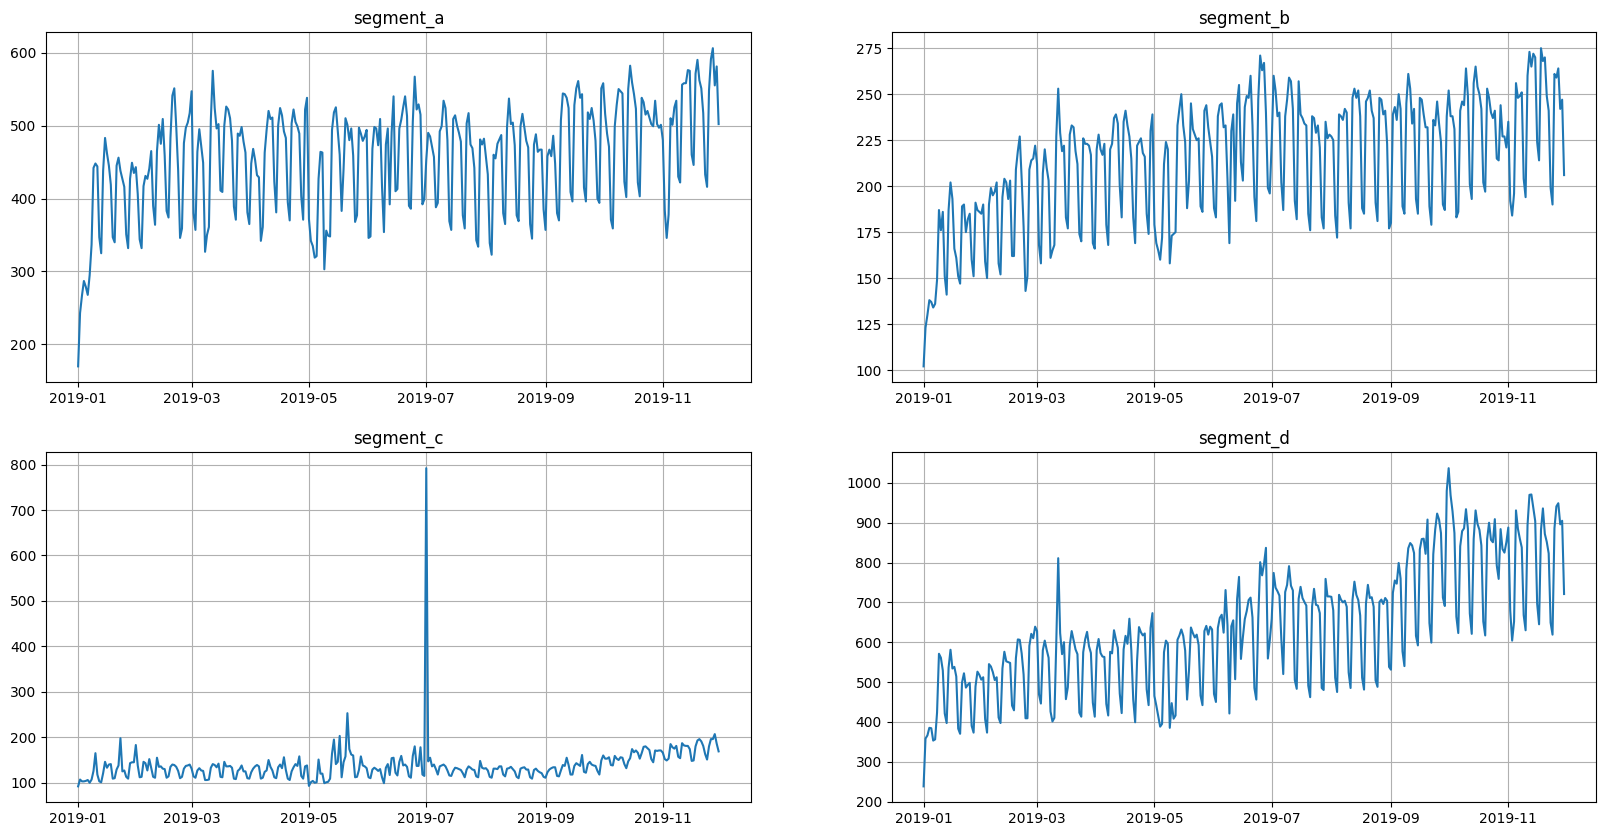

In [13]:
from etna.datasets import TSDataset

df = TSDataset.to_dataset(df)
full_ts = TSDataset(df, freq="D")
full_ts.plot()

Let's divide current dataset into train and validation parts. We will use validation part later to check final results.

In [14]:
ts, _ = full_ts.train_test_split(test_size=HORIZON * 5)

#### 1.2.2 Running `Tune`

We are going to define our `Tune` object:

In [15]:
from etna.metrics import SMAPE
from etna.auto import Tune


tune = Tune(pipeline=pipeline, target_metric=SMAPE(), horizon=HORIZON, backtest_params=dict(n_folds=5))

We used mostly default parameters for this example. But for your own experiments you might want to also set up other parameters. 

For example, parameter `runner` allows you to run tuning in parallel on a local machine, and parameter `storage` makes it possible to store optuna results on a dedicated remote server.

For a full list of parameters we advise you to check our documentation.

Let's hide the logs of optuna, there are too many of them for a notebook.

In [16]:
import optuna


optuna.logging.set_verbosity(optuna.logging.CRITICAL)

Let's run the tuning

In [17]:
%%capture
best_pipeline = tune.fit(ts=ts, n_trials=20)

Command `%%capture` just hides the output.

#### 1.2.3 Analysis

In the last section dedicated to `Tune` we will look at methods for result analysis.

First of all there is `summary` method that shows us the results of optuna trials.

In [18]:
tune.summary()

,pipeline,hash,Sign_median,Sign_mean,Sign_std,Sign_percentile_5,Sign_percentile_25,Sign_percentile_75,Sign_percentile_95,SMAPE_median,...,MSE_percentile_75,MSE_percentile_95,MedAE_median,MedAE_mean,MedAE_std,MedAE_percentile_5,MedAE_percentile_25,MedAE_percentile_75,MedAE_percentile_95,state
0,Pipeline(model = LinearPerSegmentModel(fit_int...,f4f02e1d5f60b8f322a4a8a622dd1c1e,-0.500000,-0.478571,0.205204,-0.672857,-0.621429,-0.357143,-0.254286,5.806429,...,2220.282484,2953.865443,21.000232,22.334611,8.070926,14.955846,18.861388,24.473455,31.581505,TrialState.COMPLETE
1,Pipeline(model = LinearPerSegmentModel(fit_int...,3d7b7af16d71a36f3b935f69e113e22d,-0.457143,-0.485714,0.242437,-0.745714,-0.642857,-0.300000,-0.265714,5.856039,...,2644.982216,3294.855806,22.762122,23.389796,8.482028,14.897792,19.344439,26.807479,32.760543,TrialState.COMPLETE
2,Pipeline(model = LinearPerSegmentModel(fit_int...,7c7932114268832a5458acfecfb453fc,-0.200000,-0.271429,0.264447,-0.581429,-0.392857,-0.078571,-0.061429,5.693983,...,3457.757162,4209.624737,22.572681,23.336111,12.049564,11.235277,18.503043,27.405750,36.505748,TrialState.COMPLETE
3,Pipeline(model = LinearPerSegmentModel(fit_int...,b7ac5f7fcf9c8959626befe263a9d561,0.000000,-0.085714,0.211248,-0.340000,-0.100000,0.014286,0.048571,7.881275,...,5039.841145,5665.228696,35.976862,33.937644,17.252826,14.444379,27.282228,42.632278,50.576005,TrialState.COMPLETE
4,Pipeline(model = LinearPerSegmentModel(fit_int...,e928929f89156d88ef49e28abaf55847,-0.414286,-0.421429,0.207840,-0.620000,-0.585714,-0.250000,-0.232857,6.032319,...,3091.962427,3181.592755,23.166650,25.265089,13.224461,13.001779,18.666844,29.764896,40.466215,TrialState.COMPLETE
5,Pipeline(model = LinearPerSegmentModel(fit_int...,3b4311d41fcaab7307235ea23b6d4599,-0.400000,-0.385714,0.396927,-0.788571,-0.514286,-0.271429,0.037143,6.653462,...,3800.976318,4837.444681,35.792514,32.276030,16.296588,13.499409,24.106508,43.962035,46.129572,TrialState.COMPLETE
6,Pipeline(model = LinearPerSegmentModel(fit_int...,74065ebc11c81bed6a9819d026c7cd84,-0.442857,-0.435714,0.246196,-0.672857,-0.621429,-0.257143,-0.188571,5.739626,...,2933.246064,4802.299660,27.304852,24.936077,8.294963,15.108636,21.478207,30.762723,31.447233,TrialState.COMPLETE
7,Pipeline(model = LinearPerSegmentModel(fit_int...,b0d0420255c6117045f8254bf8f377a0,-0.442857,-0.464286,0.260167,-0.725714,-0.657143,-0.250000,-0.232857,6.042134,...,2682.735922,3688.168155,28.393903,25.819143,8.652993,15.618131,21.989342,32.223704,32.415490,TrialState.COMPLETE
8,Pipeline(model = LinearPerSegmentModel(fit_int...,25dcd8bb095f87a1ffc499fa6a83ef5d,-0.457143,-0.457143,0.265986,-0.705714,-0.671429,-0.242857,-0.208571,5.869280,...,3098.567787,3154.538337,22.380642,24.289797,11.998603,13.252341,19.168974,27.501465,38.000072,TrialState.COMPLETE
9,Pipeline(model = LinearPerSegmentModel(fit_int...,3f1ca1759261598081fa3bb2f32fe0ac,-0.414286,-0.435714,0.292654,-0.725714,-0.657143,-0.192857,-0.175714,6.608191,...,3044.388978,3611.477391,23.750327,26.488927,13.825791,14.242057,20.027917,30.211337,42.569838,TrialState.COMPLETE


Let's show only the columns we are interested in.

In [19]:
tune.summary()[["hash", "pipeline", "SMAPE_mean", "state"]].sort_values("SMAPE_mean")

,hash,pipeline,SMAPE_mean,state
19,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,TrialState.COMPLETE
17,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,TrialState.COMPLETE
16,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,TrialState.COMPLETE
15,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,TrialState.COMPLETE
14,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,TrialState.COMPLETE
13,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,TrialState.COMPLETE
12,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,TrialState.COMPLETE
10,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,TrialState.COMPLETE
11,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,TrialState.COMPLETE
2,7c7932114268832a5458acfecfb453fc,Pipeline(model = LinearPerSegmentModel(fit_int...,9.210183,TrialState.COMPLETE


As we can see, we have duplicate lines according to the `hash` column. Some trials have the same sampled hyperparameters and they have the same results. We have a special handling for such duplicates: they are skipped during optimization and the previously computed metric values are returned.

Duplicates on the summary can be eliminated using `hash` column.

In [20]:
tune.summary()[["hash", "pipeline", "SMAPE_mean", "state"]].sort_values("SMAPE_mean").drop_duplicates(subset="hash")

,hash,pipeline,SMAPE_mean,state
19,8363309e454e72993f86f10c7fc7c137,Pipeline(model = LinearPerSegmentModel(fit_int...,8.556535,TrialState.COMPLETE
2,7c7932114268832a5458acfecfb453fc,Pipeline(model = LinearPerSegmentModel(fit_int...,9.210183,TrialState.COMPLETE
8,25dcd8bb095f87a1ffc499fa6a83ef5d,Pipeline(model = LinearPerSegmentModel(fit_int...,9.943658,TrialState.COMPLETE
4,e928929f89156d88ef49e28abaf55847,Pipeline(model = LinearPerSegmentModel(fit_int...,9.946866,TrialState.COMPLETE
0,f4f02e1d5f60b8f322a4a8a622dd1c1e,Pipeline(model = LinearPerSegmentModel(fit_int...,9.957781,TrialState.COMPLETE
18,6f595f4f43b323804c04d4cea49c169b,Pipeline(model = LinearPerSegmentModel(fit_int...,10.061742,TrialState.COMPLETE
1,3d7b7af16d71a36f3b935f69e113e22d,Pipeline(model = LinearPerSegmentModel(fit_int...,10.306909,TrialState.COMPLETE
9,3f1ca1759261598081fa3bb2f32fe0ac,Pipeline(model = LinearPerSegmentModel(fit_int...,10.554444,TrialState.COMPLETE
5,3b4311d41fcaab7307235ea23b6d4599,Pipeline(model = LinearPerSegmentModel(fit_int...,10.756703,TrialState.COMPLETE
6,74065ebc11c81bed6a9819d026c7cd84,Pipeline(model = LinearPerSegmentModel(fit_int...,10.917164,TrialState.COMPLETE


The second method `top_k` is useful when you want to check out best tried pipelines without duplicates.

In [21]:
top_3_pipelines = tune.top_k(k=3)

In [22]:
top_3_pipelines

[Pipeline(model = LinearPerSegmentModel(fit_intercept = True, ), transforms = [LagTransform(in_column = 'target', lags = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23], out_column = 'target_lag', ), DateFlagsTransform(day_number_in_week = False, day_number_in_month = True, day_number_in_year = False, week_number_in_month = True, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = 'date_flags', )], horizon = 14, ),
 Pipeline(model = LinearPerSegmentModel(fit_intercept = True, ), transforms = [LagTransform(in_column = 'target', lags = [14, 15, 16, 17, 18, 19, 20, 21, 22, 23], out_column = 'target_lag', ), DateFlagsTransform(day_number_in_week = False, day_number_in_month = True, day_number_in_year = False, week_number_in_month = True, week_number_in_year = False, month_number_in_year = False, season_number = False, year_number = False, is_weekend = False, sp

## 2. General AutoML <a class="anchor" id="chapter_2"></a>

Hyperparameters tuning is useful, but can be too narrow. In this section we move our attention to general AutoML pipeline.
In ETNA we have an `etna.auto.Auto` class for making automatic pipeline selection. It can be useful to quickly create a good baseline for your forecasting task.

### 2.1 How `Auto` works <a class="anchor" id="section_2_1"></a>

`Auto` init has similar parameters to `Tune`, but instead of `pipeline` it works with `pool`. Pool, in general, is just a list of pipelines.

During `fit` there are two stages:
- pool stage,
- tuning stage.

Pool stage is responsible for checking every pipeline suggested in a given `pool`. For each pipeline we run a backtest and compute `target_metric`. Results are saved in optuna study.

Tuning stage takes `tune_size` best pipelines according to the resuls of the pool stage. And then runs `Tune` with default `params_to_tune` for them sequentially from best to the worst. 

Limit parameters `n_trials` and `timeout` are shared between pool and tuning stages. First, we run pool stage with given `n_trials` and `timeout`. After that, the remaining values are divided equally among `tune_size` tuning steps.

### 2.2 Example <a class="anchor" id="section_2_2"></a>

We will move stright to the example.

In [23]:
from etna.auto import Auto


auto = Auto(target_metric=SMAPE(), horizon=HORIZON, backtest_params=dict(n_folds=5))

We used mostly default parameters, even pool. There is also a default `sampler`, but to make results more reproducible we fixed the `seed`.

Let's start the fitting. We can start by running only pool stage.

In [24]:
%%capture
best_pool_pipeline = auto.fit(ts=ts, tune_size=0)

In [25]:
auto.summary()[["hash", "pipeline", "SMAPE_mean", "state", "study"]].sort_values("SMAPE_mean")

,hash,pipeline,SMAPE_mean,state,study
15,af8088ac0abfde46e93a8dbb407a2117,Pipeline(model = CatBoostPerSegmentModel(itera...,5.057438,TrialState.COMPLETE,pool
2,d8215d95e2c6c9a4b4fdacf3fa77dddc,"Pipeline(model = NaiveModel(lag = 7, ), transf...",5.164436,TrialState.COMPLETE,pool
14,8f640faabcac0552153ca19337179f3b,Pipeline(model = HoltWintersModel(trend = 'add...,5.931951,TrialState.COMPLETE,pool
10,d6a44adb551f1aec09ef37c14aed260f,Pipeline(model = SeasonalMovingAverageModel(wi...,6.197182,TrialState.COMPLETE,pool
16,16eb77200eb2fd5dc1f6f2a5067884cd,Pipeline(model = HoltWintersModel(trend = 'add...,6.347734,TrialState.COMPLETE,pool
13,4c07749e913403906cd033e4882fc4f9,Pipeline(model = SeasonalMovingAverageModel(wi...,6.529721,TrialState.COMPLETE,pool
5,6e2eb71d033b6d0607f5b6d0a7596ce9,Pipeline(model = ProphetModel(growth = 'linear...,7.799984,TrialState.COMPLETE,pool
17,6bb58e7ce09eab00448d5732240ec2ec,Pipeline(model = CatBoostMultiSegmentModel(ite...,7.814187,TrialState.COMPLETE,pool
18,a640ddfb767ea0cbf31751ddda6e36ee,Pipeline(model = CatBoostMultiSegmentModel(ite...,7.816528,TrialState.COMPLETE,pool
9,cfeb21bcf2e922a390ade8be9d845e0d,Pipeline(model = ProphetModel(growth = 'linear...,7.893421,TrialState.COMPLETE,pool


We can continue our training. The pool stage is over and there will be only the tuning stage. If we don't want to wait forever we should limit the tuning by fixing `n_trials` or `timeout`. 

We also set some parameters for `optuna.Study.optimize`: 
- `gc_after_trial=True`: to prevent `fit` from increasing memory consumption
- `catch=(Exception,)`: to prevent failing if some trials are erroneous.

In [26]:
%%capture
best_tuning_pipeline = auto.fit(ts=ts, tune_size=3, n_trials=100, gc_after_trial=True, catch=(Exception,))

Let's look at the results.

In [27]:
auto.summary()[["hash", "pipeline", "SMAPE_mean", "state", "study"]].sort_values("SMAPE_mean").drop_duplicates(
    subset=("hash", "study")
).head(10)

,hash,pipeline,SMAPE_mean,state,study
56,419fc80cf634ba0888c4f899f666ad45,Pipeline(model = HoltWintersModel(trend = 'mul...,4.769471,TrialState.COMPLETE,tuning/8f640faabcac0552153ca19337179f3b
89,731ccb72a473bec81789b7f186001ddd,Pipeline(model = CatBoostPerSegmentModel(itera...,4.899715,TrialState.COMPLETE,tuning/af8088ac0abfde46e93a8dbb407a2117
97,9c302769456b4adb9143f11c582f7264,Pipeline(model = CatBoostPerSegmentModel(itera...,4.927197,TrialState.COMPLETE,tuning/af8088ac0abfde46e93a8dbb407a2117
88,182c748af70287ab3a12bf32c03320f5,Pipeline(model = CatBoostPerSegmentModel(itera...,4.941247,TrialState.COMPLETE,tuning/af8088ac0abfde46e93a8dbb407a2117
96,4f426335c0eb00d847d9dd1e0a421415,Pipeline(model = CatBoostPerSegmentModel(itera...,4.977773,TrialState.COMPLETE,tuning/af8088ac0abfde46e93a8dbb407a2117
98,2cafd0750f191e7ab2d4160da50a7c64,Pipeline(model = CatBoostPerSegmentModel(itera...,5.056993,TrialState.COMPLETE,tuning/af8088ac0abfde46e93a8dbb407a2117
15,af8088ac0abfde46e93a8dbb407a2117,Pipeline(model = CatBoostPerSegmentModel(itera...,5.057438,TrialState.COMPLETE,pool
75,382825866425cac211691205a9537c95,Pipeline(model = CatBoostPerSegmentModel(itera...,5.081609,TrialState.COMPLETE,tuning/af8088ac0abfde46e93a8dbb407a2117
95,c2a8d498fe35873d060e173e1af042d5,Pipeline(model = CatBoostPerSegmentModel(itera...,5.117583,TrialState.COMPLETE,tuning/af8088ac0abfde46e93a8dbb407a2117
91,035f8e28180bc7491a30b3d0d67060c9,Pipeline(model = CatBoostPerSegmentModel(itera...,5.135956,TrialState.COMPLETE,tuning/af8088ac0abfde46e93a8dbb407a2117


In [28]:
auto.top_k(k=5)

[Pipeline(model = HoltWintersModel(trend = 'mul', damped_trend = False, seasonal = 'mul', seasonal_periods = None, initialization_method = 'estimated', initial_level = None, initial_trend = None, initial_seasonal = None, use_boxcox = True, bounds = None, dates = None, freq = None, missing = 'none', smoothing_level = None, smoothing_trend = None, smoothing_seasonal = None, damping_trend = None, ), transforms = [], horizon = 14, ),
 Pipeline(model = CatBoostPerSegmentModel(iterations = None, depth = 9, learning_rate = 0.0435214895575014, logging_level = 'Silent', l2_leaf_reg = 1.588756097852857, thread_count = None, random_strength = 0.0001602176189749599, ), transforms = [LagTransform(in_column = 'target', lags = [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = False, day_number_in_year = False, week_number_in_month = False, week_number_in_year = False, month_number_in_year = False, season

If we look at `study` column we will see that best trial from tuning stage is better then best trial from pool stage. It means, that tuning stage was successful and improved the final result. 

Let's compare best pipeline on pool and tuning stages on hold-out part of initial `ts`.

In [29]:
%%capture
best_pool_metrics, _, _ = best_pool_pipeline.backtest(ts=full_ts, metrics=[SMAPE()], n_folds=5)
best_tuning_metrics, _, _ = best_tuning_pipeline.backtest(ts=full_ts, metrics=[SMAPE()], n_folds=5)

In [30]:
best_pool_smape = best_pool_metrics["SMAPE"].mean()
best_tuning_smape = best_tuning_metrics["SMAPE"].mean()
print(f"Best pool SMAPE: {best_pool_smape:.3f}")
print(f"Best tuning SMAPE: {best_tuning_smape:.3f}")

Best pool SMAPE: 8.262
Best tuning SMAPE: 8.188


As we can see, the results are slightly better after the tuning stage, but it can be statistically insignificant. For your datasets the results could be different.

## 3. Summary

In this notebook we discussed how AutoML works in ETNA library and how to use it. There are two supported scenarios:
- Tuning your existing pipeline;
- Automatic search of the pipeline for your forecasting task.